# 3 - Análise Exploratória de Séries Temporais - Faturamento do produto `auxilio_final_de_ano`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma continuação da análise exploratória inicial.

Neste notebook, vamos progredir para a análise exploratória de séries temporais do faturamento do produto `auxilio_final_de_ano`.

In [1]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'auxilio_final_de_ano'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

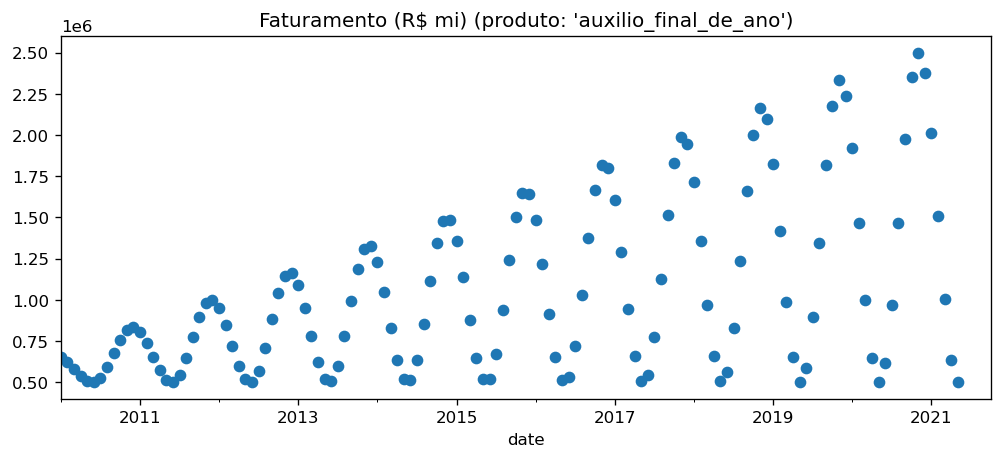

In [3]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ mi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [4]:
fat.describe()

count    1.370000e+02
mean     1.061174e+06
std      5.249966e+05
min      5.000000e+05
25%      6.331345e+05
50%      9.129011e+05
75%      1.375567e+06
max      2.500000e+06
Name: auxilio_final_de_ano, dtype: float64

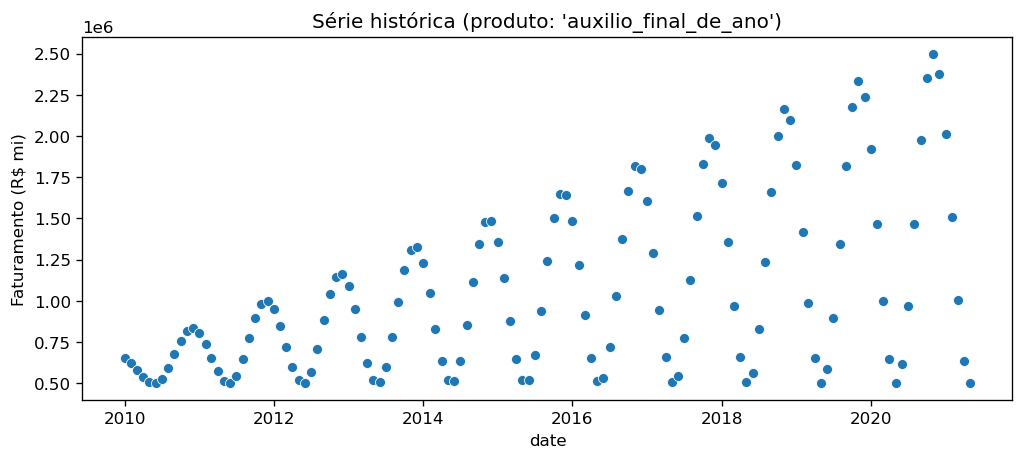

In [5]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ mi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

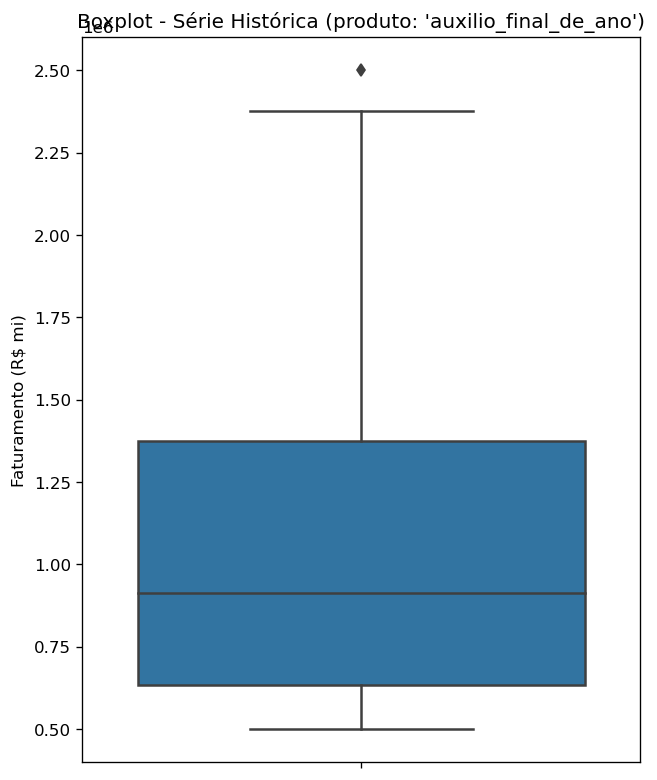

In [6]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

Os *outliers* da série histórica indicados no *boxplot* acima são provavelmente decorrentes do comportamento oscilatório dos faturamentos se tornarem mais acentuados conforme o tempo passa.

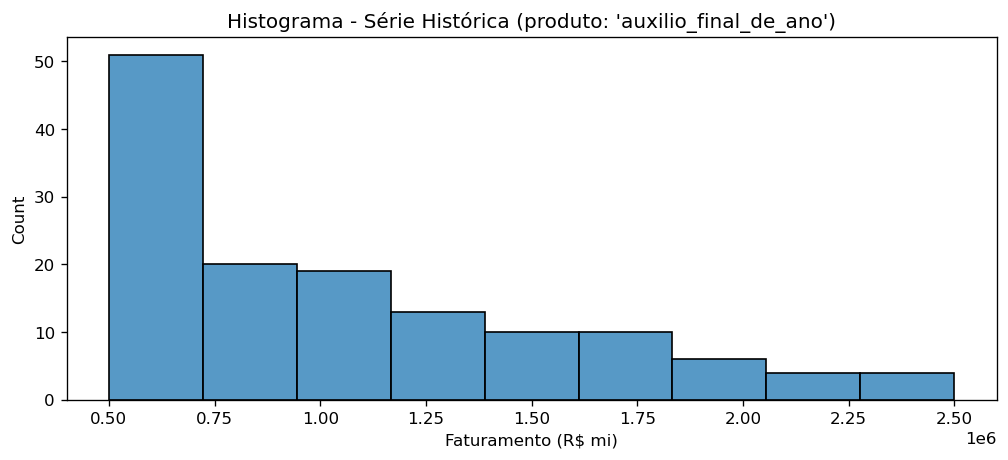

In [7]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ mi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [8]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.000000e+01
mean     1.356653e+06
std      6.591265e+05
min      5.000000e+05
25%      6.560182e+05
50%      1.351597e+06
75%      1.981791e+06
max      2.500000e+06
Name: auxilio_final_de_ano, dtype: float64

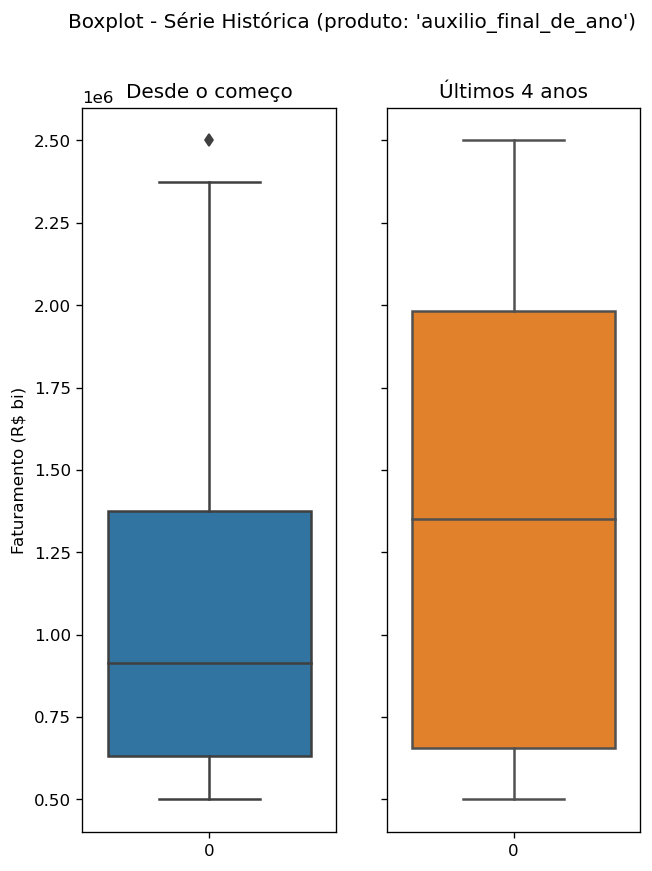

In [9]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

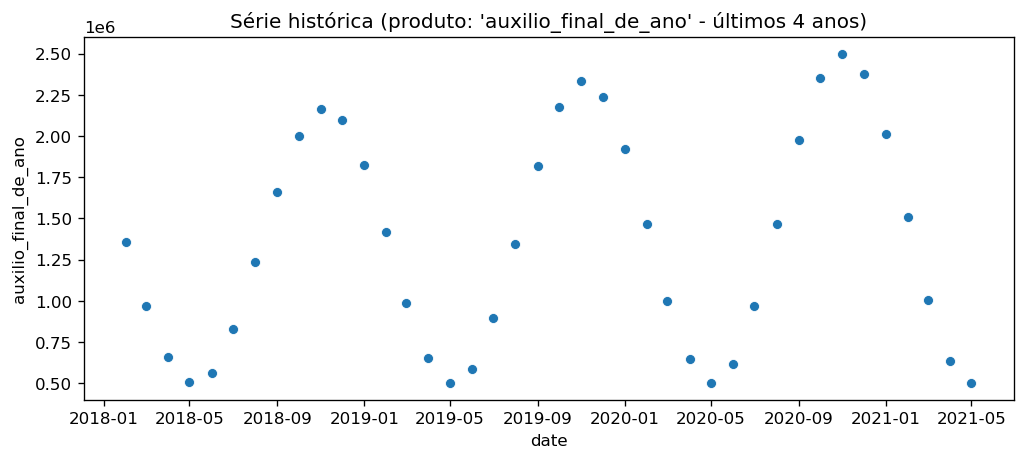

In [10]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

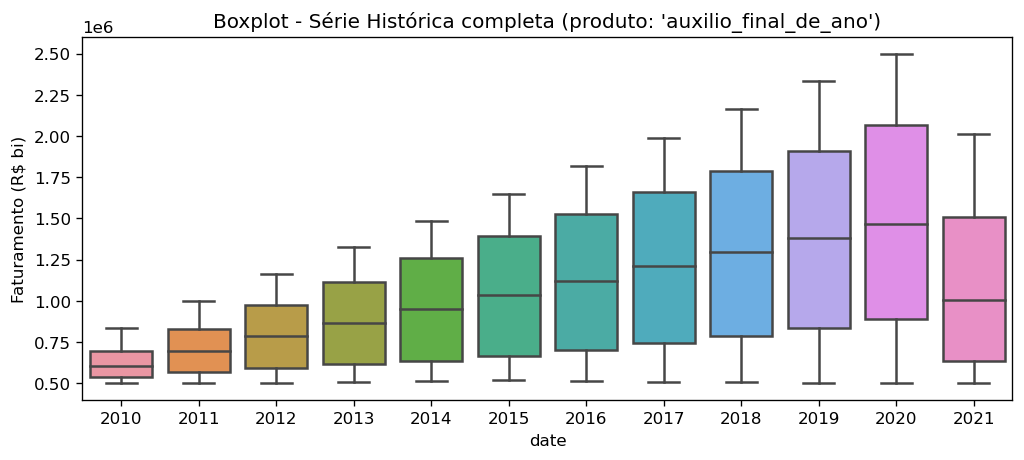

In [11]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

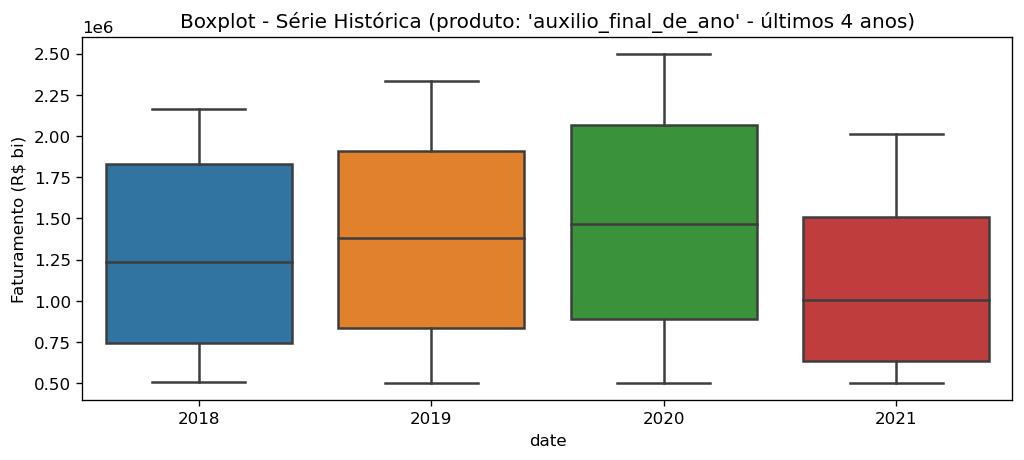

In [12]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [13]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

Nota-se que a série atingiu uma certa estabilidade por volta de meados de 2017:

In [14]:
testedf = adfuller(fat.dropna())
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 92.419% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

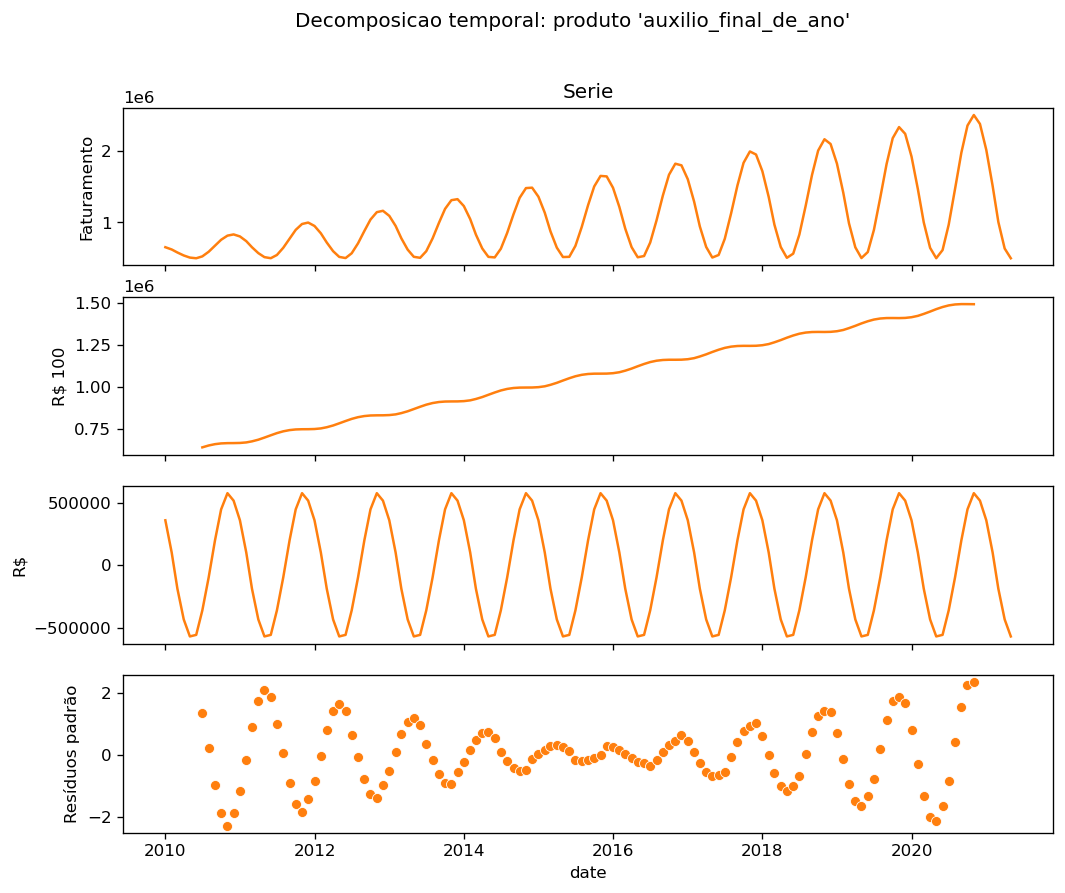

In [15]:
i = i_palette[analise_produto]
c = seaborn_palette[i]

decomp = py_scripts.plots.decomp_fourier(serie_fat = fat.dropna(), produto = analise_produto, c = c)

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos claramente seguem um padrão oscilatório.

Vamos ver o que ocorre quanto tentamos projetar essa série para o futuro.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

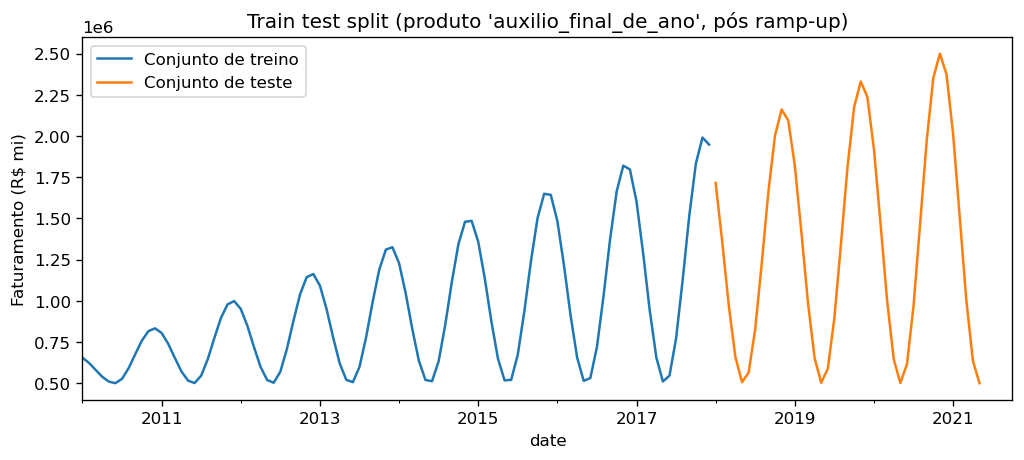

In [16]:
# após ramp-up
fat_modelo = fat

train_test_split_idx = int(fat_modelo.dropna().shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}', pós ramp-up)")
plt.ylabel('Faturamento (R$ mi)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) pode ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

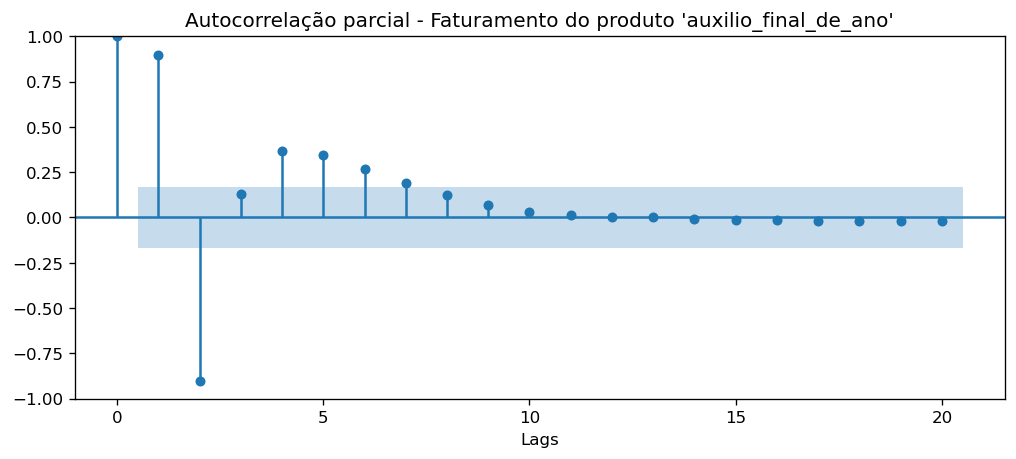

In [17]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo.dropna(), lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d, D \sim 4$.

In [18]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = None, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )


In [19]:
# modelos_aceitaveis = [
#     ARIMA(order = (0, 0, 1), seasonal_order=(1, 4, 1, 12), with_intercept = True).fit(y = fat_train),
#     ARIMA(order = (0, 0, 0), seasonal_order=(1, 4, 1, 12), with_intercept = True).fit(y = fat_train)
# ]

In [70]:
modelo = ARIMA(order = (0, 0, 0), seasonal_order=(1, 4, 1, 12), with_intercept = True).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   96
Model:             SARIMAX(1, 4, [1], 12)   Log Likelihood                -134.560
Date:                    Thu, 18 Nov 2021   AIC                            277.119
Time:                            20:47:51   BIC                            284.604
Sample:                                 0   HQIC                           279.948
                                     - 96                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4115      0.159      2.583      0.010       0.099       0.724
ar.S.L12       0.9977      0.001   1034.446      0.000       0.996       1.000
ma.S.L12       0.6831      0.346      1.973      0.048       0.005       1.362
sigma2         0.1868      0.050      3.729      0.000       0.089       0.285
===================================================================================
Ljung-Box (L1) (Q):                  29.26   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.00   Prob(JB):                         0.92
Heteroskedasticity (H):               1.01   Skew:                             0.14
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

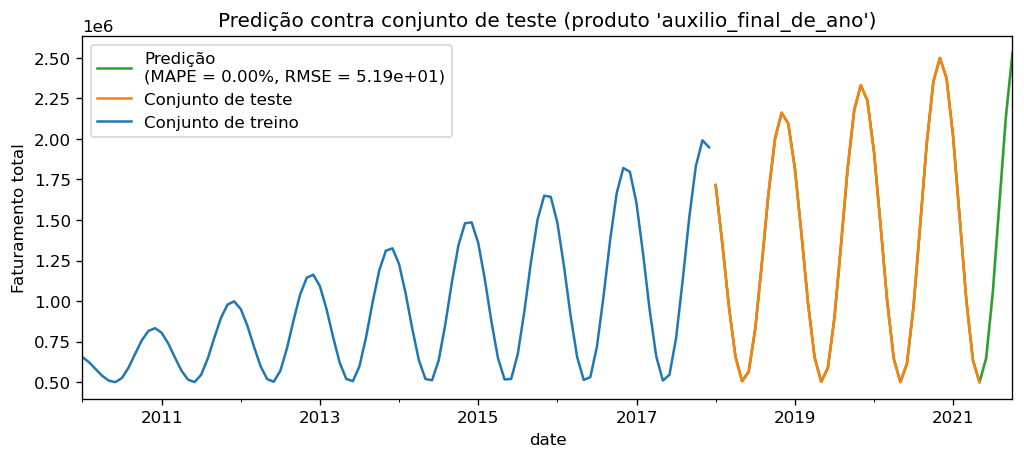

In [72]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Vamos aplicar alguns diagnósticos aos resíduos do modelo:

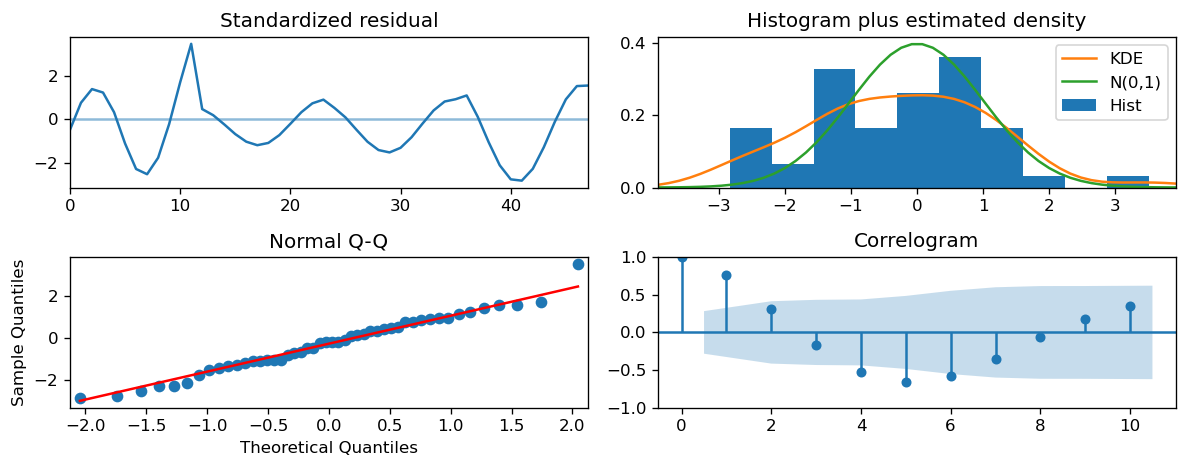

In [73]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [23]:
kwargs_total = dict(
    y_true = fat_test.dropna(),
    y_pred = preds.loc[fat_test.dropna().index],
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 0.00%
       RMSE: 5.19e+01
        MAE: 2.95e+01
